<a href="https://colab.research.google.com/github/Mithil01/Marketing-ad-campaign-experimentation-/blob/main/AB_Testing_Marketing_Ad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Intro

## Business Problem:

- As a product data scientist at Marketing company, goal is to design, run and analyze an AB experiment that tests conversion of users for two groups - one with product advertisement and other with Public Service Announcement(PSA).


- The control is the Public Service Announcement group. The treatment is the product advertisement group.

- Help the product team decide which version to use based on the AB test result.

In [1]:
!unzip archive.zip

Archive:  archive.zip
  inflating: marketing_AB.csv        


In [2]:
from datetime import datetime
import random
import math

# Third-party libraries
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion import proportions_chisquare, confint_proportions_2indep
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power
from sklearn.model_selection import train_test_split
# Disable warnings
from warnings import filterwarnings
filterwarnings('ignore')

# Set seed for np random
SEED = 201
np.random.seed(SEED)

# Step 1 - Understand the Business Problem




## Table Summary

In [3]:
data = pd.read_csv('marketing_AB.csv')

In [4]:
data.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [5]:
# Show stats about the data table

# 1. How many rows are in the data table.
# 2. Proportion of 'ad' and 'psa' groups.

print('No. of rows:', data.shape[0])
print('Test group compostion : ', data['test group'].value_counts())

No. of rows: 588101
Test group compostion :  ad     564577
psa     23524
Name: test group, dtype: int64


In [6]:
# Let's check for missingness. What's the null rate per column?
data.isnull().mean()

Unnamed: 0       0.0
user id          0.0
test group       0.0
converted        0.0
total ads        0.0
most ads day     0.0
most ads hour    0.0
dtype: float64

In [7]:
# Mapping False :0 and True:1
data['converted'] = data['converted'].map({False:0, True:1})

In [8]:
data.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,0,130,Monday,20
1,1,1119715,ad,0,93,Tuesday,22
2,2,1144181,ad,0,21,Tuesday,18
3,3,1435133,ad,0,355,Tuesday,10
4,4,1015700,ad,0,276,Friday,14


In [9]:
# Let's get some stats about the data performance

# A. How many users were there?
# B. How many conversions were there
# C. What was the conversion rate?

print('Total user count:', data['user id'].nunique())
print('conversions count:', data.converted.sum())
print('conversion rate:', data.converted.mean().round(2))

Total user count: 588101
conversions count: 14843
conversion rate: 0.03


## EDA on marketing campaigns.

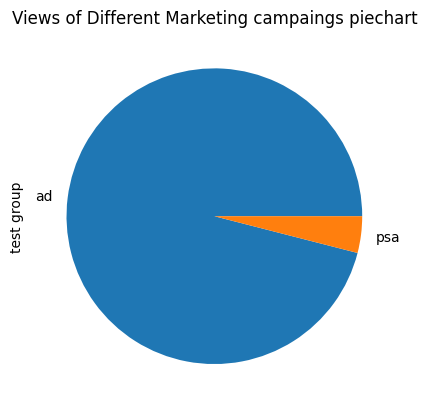

In [23]:
ax = data["test group"].value_counts().plot(kind="pie")
ax.set_title('Views of Different Marketing campaings piechart')
plt.show()

### Converted Piechart

% Not converted :  97.4761137967798
% Converted :  2.523886203220195




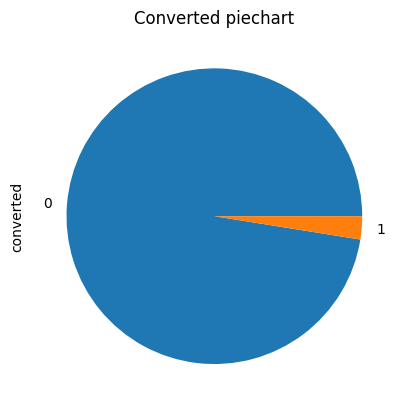

In [25]:
print("% Not converted : ", 100 * data["converted"].value_counts()[0]/data["converted"].value_counts().sum())
print("% Converted : ", 100 * data["converted"].value_counts()[1]/data["converted"].value_counts().sum())
print("\n")
ax = data["converted"].value_counts().plot(kind="pie")
ax.set_title('Converted piechart')
plt.show()

### Converted per group(ad and psa)

<Axes: xlabel='test group'>

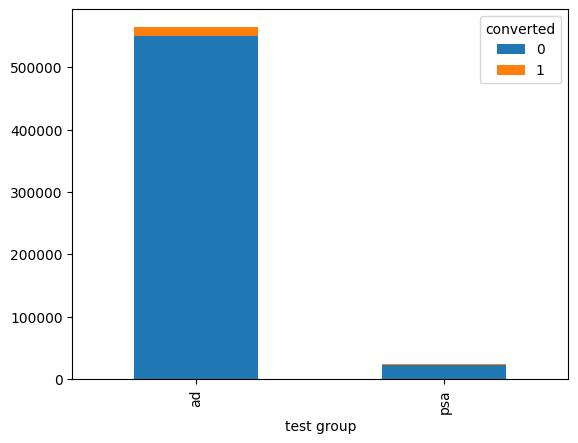

In [28]:
data.groupby("converted")["test group"].value_counts().unstack()

data.groupby("converted")["test group"].value_counts().unstack('converted').plot(kind="bar", stacked=True)

### Most Profitable Days for campaign

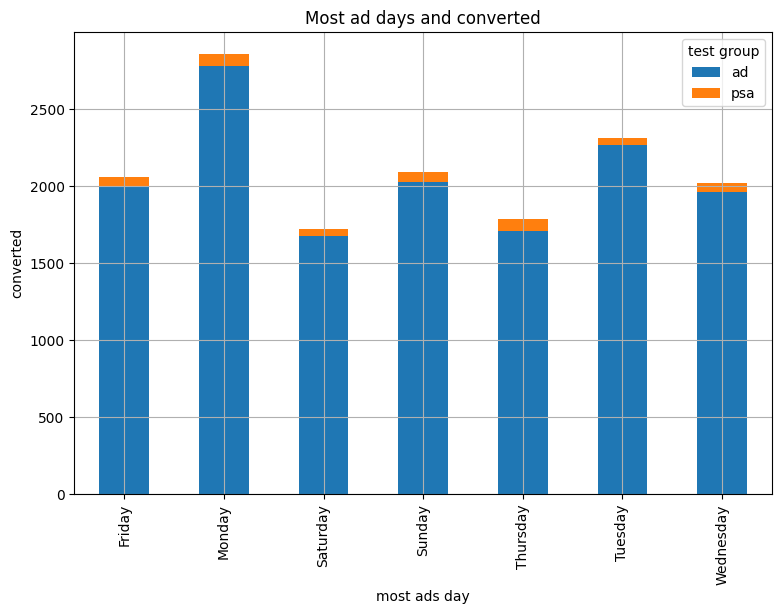

In [29]:
ax = data.groupby(by =['most ads day', 'test group']).sum()['converted'].unstack('test group').plot(kind='bar', figsize=(9,6), grid= True, stacked= True)
ax.set_ylabel('converted')
ax.set_title('Most ad days and converted')
plt.show()

### Observation: Most profitable day for ad-campaign was Monday and least profitable day was Saturday.

## Visitor count per day

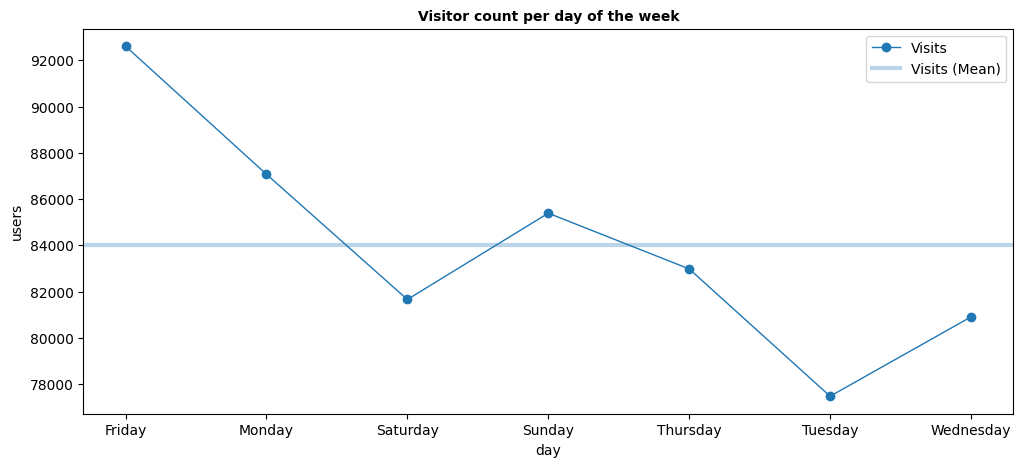

In [33]:
# Set the color palette for the plot
colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

# Count conversion by day of the week
visitors_per_day = data.groupby('most ads day')['converted'].count()
conversions_mean = visitors_per_day.mean()

# Plot data
f, ax = plt.subplots(figsize=(12, 5))
plt.plot(visitors_per_day.index, visitors_per_day, '-o', color=c1, linewidth=1, label='Visits')
plt.axhline(conversions_mean, color=c1, linestyle='-', linewidth=3, alpha=0.3, label='Visits (Mean)')

# plot
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.title('Visitor count per day of the week', fontsize=10, weight='bold')
plt.ylabel('users', fontsize=10)
plt.xlabel('day', fontsize=10)
plt.legend()

plt.show()

### Conversion Rate per day-of-week


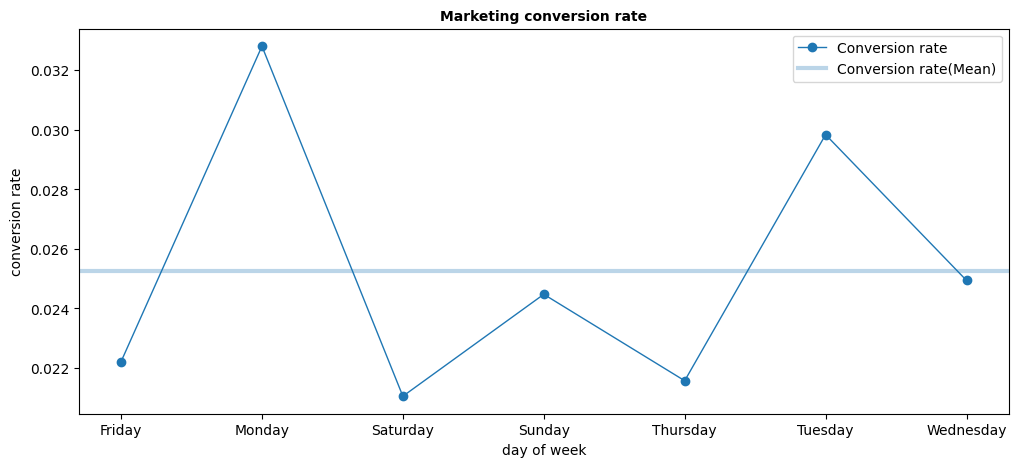

In [11]:
# Set the color palette for the plot
colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

# Conversion rate by hour
conversion_rate_per_day = data.groupby('most ads day')['converted'].mean()
conversion_rate_mean = conversion_rate_per_day.mean()

# Plot data
f, ax = plt.subplots(figsize=(12, 5))
plt.plot(conversion_rate_per_day.index, conversion_rate_per_day, '-o', color=c1, linewidth=1, label='Conversion rate')
plt.axhline(conversion_rate_mean, color=c1, linestyle='-', linewidth=3, alpha=0.3, label='Conversion rate(Mean)')

# Format plot
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.title('Marketing conversion rate', fontsize=10, weight='bold')
plt.ylabel('conversion rate', fontsize=10)
plt.xlabel('day of week', fontsize=10)
plt.legend()

plt.show()

## Step 2

The second step of the experiment is to state the hypothesis. This is followed by setting parameter values such as the significance level (alpha), statistical power and minimum detctable effect (MDE).

**Ho:** The conversion rates of psa(control) and ad(treatment) groups are same.<br>
**Ha:** The conversion rates of psa(control) and ad(treatment) groups are different.

In [14]:
#Experiment parameters
alpha = 0.05  # Set the probability threshold at 0.05. If the p-value is less than 0.05, reject Ho.
power = 0.80  # Ensure that there's 80% chance of detecting an effect with significance
mde = 0.10    # Detect a 10% improvement of the conversion rate with statistical significance

# Proportions if the effect exists
p1 = 0.10          # Control(psa)
p2 = p1 * (1 + p1)  # Treatment(ad)

# Step 3 - Design the Experiment

The third step of the experiment is the design the experiment which involves calculating the sample size.

To detect an effect of 10.0% lift from the old conversion-rate at 10%, 
The sample size per group required is 15000.
 The total sample required in the experiment is 30000.


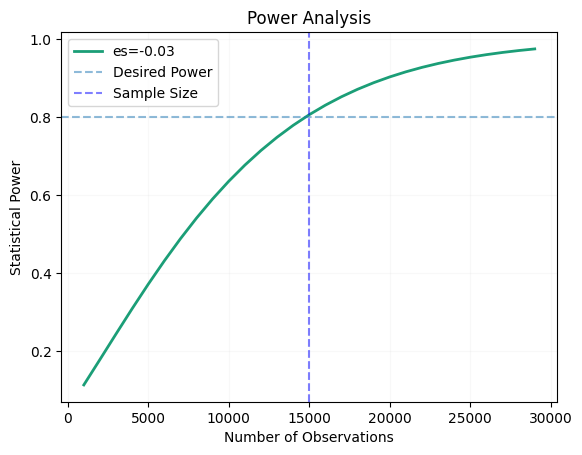

In [15]:
# Calculate the effect size using Cohen's D
cohen_D = sm.stats.proportion_effectsize(p1, p2)

# Estimate the sample size required per group
n = tt_ind_solve_power(effect_size=cohen_D, power=power, alpha=alpha)
n = int(round(n, -3)) # Round up to nearest k
N = 2*n #total sample size

print(f'To detect an effect of {100*(p2/p1-1):.1f}% lift from the old conversion-rate at {100*p1:.0f}%, ')
print(f'The sample size per group required is {n}.')
print(f' The total sample required in the experiment is {N}.')

# Explore power across sample sizes
ttest_power = TTestIndPower()
ttest_power.plot_power(dep_var='nobs', nobs=np.arange(1000,30000,1000), effect_size=[cohen_D], title='Power Analysis')

# Set plot parameters
plt.axhline(0.8, linestyle='--', label='Desired Power', alpha=0.5)
plt.axvline(n, linestyle='--', color='blue', label='Sample Size', alpha=0.5)
plt.ylabel('Statistical Power')
plt.grid(alpha=0.08)
plt.legend()
plt.show()

## Step 4 - Run the Experiment
###  - Lets first group the dataframee into 'psa' and 'ad' group.

In [16]:
nonad_group = data[data['test group'] == 'psa']['converted']
ad_group = data[data['test group'] == 'ad']['converted']

In [17]:
#As described in the step 3 : inorder to achieve statistical power of 80%, minimum samples needed is 15000.

control_conversions = nonad_group.sample(n = 15000, replace = False)
treatment_conversions = ad_group.sample(n = 15000, replace = False)

# Get stats
AB_control_cnt = control_conversions.sum()          # Control conversions Count
AB_treatment_cnt = treatment_conversions.sum()      # Treatment conversions Count
AB_control_rate = control_conversions.mean()        # Control conversions Rate
AB_treatment_rate = treatment_conversions.mean()    # Treatment conversions Rate
AB_control_size = control_conversions.count()       # Control conversions Size
AB_treatment_size = treatment_conversions.count()   # Treatment conversions Size

# Show calculation
print(f'Control conversions Rate: {AB_control_rate:.4}')
print(f'Treatment conversions Rate: {AB_treatment_rate:.4}')

Control conversions Rate: 0.0172
Treatment conversions Rate: 0.02607


## Observation : it can be clearly seen that treatment group conversion rate is higher than control group conversion rate. Hence, H0(conversion rates of both groups are same) can be rejected.

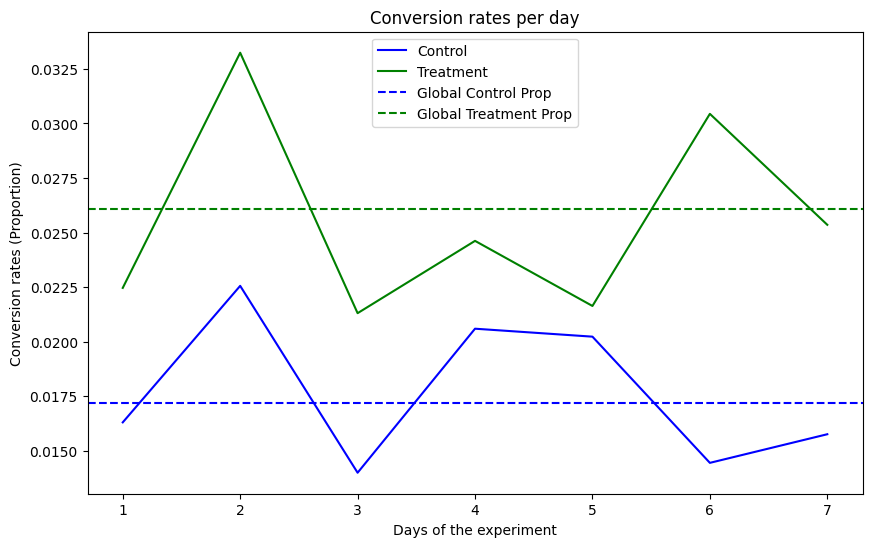

In [18]:
# Calculate the conversion rates per day
conversions_per_day = data.groupby(['test group','most ads day'])['converted'].mean()
ctrl_props = conversions_per_day.loc['psa']
trt_props = conversions_per_day.loc['ad']

# Get the day range of experiment
exp_day = range(1, data['most ads day'].nunique() + 1)

# Let's display the conversion rate per day
f, ax = plt.subplots(figsize=(10, 6))

# plots
ax.plot(exp_day, ctrl_props, label = 'Control', color='b')
ax.plot(exp_day, trt_props, label = 'Treatment', color='g')
ax.axhline(AB_control_rate, label = 'Global Control Prop', linestyle='--', color='b')
ax.axhline(AB_treatment_rate, label = 'Global Treatment Prop', linestyle='--', color='g')

ax.set_xticks(exp_day)
ax.set_title('Conversion rates per day')
ax.set_ylabel('Conversion rates (Proportion)')
ax.set_xlabel('Days of the experiment')
ax.legend()
plt.show()

## Step 5 - Conduct Statistical Inference

- Here, we will look if there is actually statistical significance for rejecting null hypothesis(H0).

- For this, we will perform Chi-Squares test(Two sample single tailed test of proportions) and also Confidence Interval.

In [19]:
# Set the ALPHA for the AB test
AB_ALPHA = 0.05

In [20]:
# Perform the chi-squared test

# Execute test
AB_chistats, AB_pvalue, AB_tab = proportions_chisquare([AB_control_cnt, AB_treatment_cnt], nobs=[AB_control_size, AB_treatment_size])

# Run results
print(f'------ AB Test Conversions --------\n')
print('Ho: The conversion rates between psa(control) and ad(treatment) groups are the same.')
print('Ha: The conversion rates between psa(control) and ad(treatment) groups are the different.\n')
print(f'Significance level: {AB_ALPHA}')

print(f'Chi-Square = {AB_chistats:.3f} | P-value = {AB_pvalue:.3f}')

print("Decision : ")
if AB_pvalue < AB_ALPHA:
  print('Decision : Reject Ho and conclude that there is statistical significance in the difference of conversion rates between psa and ad groups.')
else:
  print('Decision : Fail to reject Ho.')

------ AB Test Conversions --------

Ho: The conversion rates between psa(control) and ad(treatment) groups are the same.
Ha: The conversion rates between psa(control) and ad(treatment) groups are the different.

Significance level: 0.05
Chi-Square = 27.858 | P-value = 0.000
Decision : 
Decision : Reject Ho and conclude that there is statistical significance in the difference of conversion rates between psa and ad groups.


In [21]:
# Compute the Confidence Interval of the Test
ci = confint_proportions_2indep(AB_treatment_cnt, AB_treatment_size, AB_control_cnt, AB_control_size, method=None, compare='diff', alpha=0.05, correction=True)
lower = ci[0]
upper = ci[1]
lower_lift = ci[0] / AB_control_rate
upper_lift = ci[1] / AB_control_rate

In [34]:
# Print results
print('--------- Sample Sizes ----------')
print(f'Control: {AB_control_size}')
print(f'Treatment: {AB_treatment_size}')

print('\n------Conversion Counts (Rates) --------')
print(f'Control: {AB_control_cnt} ({AB_control_rate*100:.1f}%)')
print(f'Treatment: {AB_treatment_cnt} ({AB_treatment_rate*100:.1f}%)')

print('\n----- Differences -----')
print(f'Absolute: {AB_treatment_rate - AB_control_rate:.4f}')
print(f'Relative (lift): {(AB_treatment_rate - AB_control_rate) / AB_control_rate*100:.1f}%')

print('\n------- Confidence Intervals --------')
print(f'Absolute Difference CI: ({lower:.3f}, {upper:.3f})')
print(f'Relative Difference (lift) CI: ({lower_lift*100:.1f}%, {upper_lift*100:.1f}%)')

--------- Sample Sizes ----------
Control: 15000
Treatment: 15000

------Conversion Counts (Rates) --------
Control: 258 (1.7%)
Treatment: 391 (2.6%)

----- Differences -----
Absolute: 0.0089
Relative (lift): 51.6%

------- Confidence Intervals --------
Absolute Difference CI: (0.006, 0.012)
Relative Difference (lift) CI: (32.5%, 70.8%)


## Step 7 - Decide Whether to Launch
In the Marketing ad-campaign, we aimed to check if personalized-ad would increase the conversion rate.

We ran AB test on sample of users into the control (psa) and treatment (ad) groups.

From the test, we observed an improvement of 51.6% lift from the benchmark at 1.7%. The result was statistically significant with a 95% confidence interval between 32.5% and 70.8%.

Given that we observed practical and statistical significance, our recommendation is to launch marketing campaign with personalized ads.
